In [1]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

In [3]:
def set_seed(seed = 16):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
train_files = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']
images = np.array([],dtype=np.uint8).reshape((0,3072))
labels = np.array([])
for tf in train_files:
    data_dict = unpickle('/kaggle/input/cifar10-python/cifar-10-batches-py/'+tf)
    data = data_dict[b'data']
    images = np.append(images,data,axis=0)
    labels = np.append(labels,data_dict[b'labels'])
#print(images.shape, labels.shape)

testimages = np.array([],dtype=np.uint8).reshape((0,3072))
testlabels = np.array([])

data_dict = unpickle('/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch')
data = data_dict[b'data']
testimages = np.append(testimages,data,axis=0)
testlabels = np.append(testlabels,data_dict[b'labels'])
#print(testimages.shape, testlabels.shape)

images = images.reshape((-1,3,32,32)).astype(np.float32)
testimages = testimages.reshape((-1,3,32,32)).astype(np.float32)

In [5]:
trimages = images[:40000]
valimages = images[40000:]
trlabels = labels[:40000]
vallabels = labels[40000:]
MEAN = np.mean(trimages/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(trimages/255.0,axis=(0,2,3),keepdims=True)

In [6]:
class C10DataGen(Dataset):
    def __init__(self,phase,imgarr,s = 0.5):
        self.phase = phase
        self.imgarr = imgarr
        self.s = s
        self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop(32,(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.2*self.s)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self,idx):
        
        x = self.imgarr[idx] 
        #print(x.shape)
        x = x.astype(np.float32)/255.0

        x1 = self.augment(torch.from_numpy(x))
        x2 = self.augment(torch.from_numpy(x))
        
        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)
        
        return x1, x2

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.imgarr = self.imgarr[random.sample(population = list(range(self.__len__())),k = self.__len__())]

    def preprocess(self,frame):
        frame = (frame-MEAN)/STD
        return frame
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, frame, transformations = None):
        
        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame
        
        return frame

In [7]:
dg = C10DataGen('train',trimages)
dl = DataLoader(dg,batch_size = 128,drop_last=True)

vdg = C10DataGen('valid',valimages)
vdl = DataLoader(vdg,batch_size = 128,drop_last=True)


In [8]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 4

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn
        
        self.linear = nn.Linear(self.in_features, 
                                self.out_features, 
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))
        
    def forward(self,x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):
    def __init__(self,base_model):
        super().__init__()
        self.base_model = base_model
        
        #PRETRAINED MODEL
        self.pretrained = models.resnet50(pretrained=True)
        
        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        
        self.pretrained.fc = Identity()
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
        
        self.projector = ProjectionHead(2048, 2048, 128)

    def forward(self,x):
        out = self.pretrained(x)
        
        xp = self.projector(torch.squeeze(out))
        
        return xp


In [10]:

model = PreModel('resnet50').to('cuda:0')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [11]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [12]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True
    

In [13]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

#LOSS FUNCTION
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 00000: adjusting learning rate of group 0 to 2.0000e-01.


In [14]:
def save_model(model, optimizer, scheduler, current_epoch, name):
    out = os.path.join('/content/saved_models/',name.format(current_epoch))

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict':scheduler.state_dict()}, out)

def plot_features(model, num_classes, num_feats, batch_size):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1,x2 in vdl:
            x1 = x1.squeeze().to(device = 'cuda:0', dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = int(batch_size*(valimages.shape[0]//batch_size))#(len(val_df)
    
    for i in range(num_classes):
        plt.scatter(x_feats[vallabels[:num_samples]==i,1],x_feats[vallabels[:num_samples]==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()


In [15]:
def save_model(model, optimizer, scheduler, current_epoch, name):
    dir_path = '/content/saved_models/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    out = os.path.join(dir_path, name.format(current_epoch))
    
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, out)

def plot_features(model, num_classes, num_feats, batch_size):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1,x2 in vdl:
            x1 = x1.squeeze().to(device = 'cuda:0', dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = int(batch_size*(valimages.shape[0]//batch_size))#(len(val_df)
    
    for i in range(num_classes):
        plt.scatter(x_feats[vallabels[:num_samples]==i,1],x_feats[vallabels[:num_samples]==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()


Epoch [0/20]	


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_24/46959966.py:129: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/python_a

Step [0/78]	 Loss: 5.2662
Step [50/78]	 Loss: 4.37867
Step [100/78]	 Loss: 4.04058
Step [150/78]	 Loss: 3.89418
Step [200/78]	 Loss: 3.83106
Step [250/78]	 Loss: 3.80436
Step [300/78]	 Loss: 3.79089
Adjusting learning rate of group 0 to 4.0000e-02.
Step [0/312]	 Loss: 3.6763
Step [50/312]	 Loss: 3.6817
Epoch [0/20]	 Training Loss: 4.055051462008403	 lr: 0.04
Epoch [0/20]	 Validation Loss: 3.6657455150897684	 lr: 0.04
Epoch [0/20]	 Time Taken: 4.7269359985987345 minutes
Epoch [1/20]	
Step [0/78]	 Loss: 3.77403
Step [50/78]	 Loss: 3.75253
Step [100/78]	 Loss: 3.76014
Step [150/78]	 Loss: 3.73964
Step [200/78]	 Loss: 3.75794
Step [250/78]	 Loss: 3.73923
Step [300/78]	 Loss: 3.7322
Adjusting learning rate of group 0 to 6.0000e-02.
Step [0/312]	 Loss: 3.66104
Step [50/312]	 Loss: 3.65848
Epoch [1/20]	 Training Loss: 3.74641821705378	 lr: 0.06
Epoch [1/20]	 Validation Loss: 3.6520251830418906	 lr: 0.06
Epoch [1/20]	 Time Taken: 4.711178998152415 minutes
Epoch [2/20]	
Step [0/78]	 Loss: 3.737

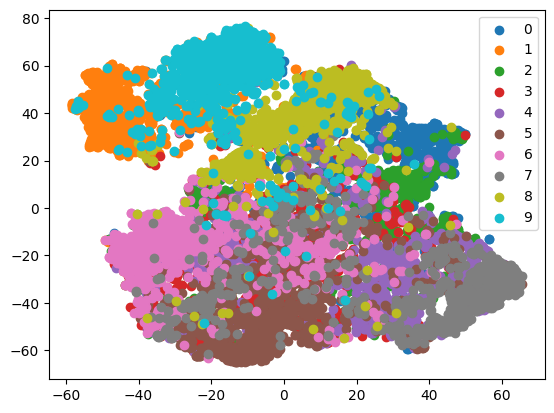

Epoch [10/20]	


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/78]	 Loss: 3.65648
Step [50/78]	 Loss: 3.65398
Step [100/78]	 Loss: 3.66291
Step [150/78]	 Loss: 3.64919
Step [200/78]	 Loss: 3.64809
Step [250/78]	 Loss: 3.65792
Step [300/78]	 Loss: 3.64193
Epoch 00001: adjusting learning rate of group 0 to 2.0000e-01.
Step [0/312]	 Loss: 3.61879
Step [50/312]	 Loss: 3.6217
Epoch [10/20]	 Training Loss: 3.6513933012118707	 lr: 0.2
Epoch [10/20]	 Validation Loss: 3.609955961887653	 lr: 0.2
Epoch [10/20]	 Time Taken: 4.705818569660186 minutes
Epoch [11/20]	
Step [0/78]	 Loss: 3.64392
Step [50/78]	 Loss: 3.65498
Step [100/78]	 Loss: 3.64456
Step [150/78]	 Loss: 3.64321
Step [200/78]	 Loss: 3.64471
Step [250/78]	 Loss: 3.63175
Step [300/78]	 Loss: 3.63695
Epoch 00002: adjusting learning rate of group 0 to 1.9999e-01.
Step [0/312]	 Loss: 3.61327
Step [50/312]	 Loss: 3.625
Epoch [11/20]	 Training Loss: 3.6465088098477096	 lr: 0.19999
Epoch [11/20]	 Validation Loss: 3.607658545176188	 lr: 0.19999
Epoch [11/20]	 Time Taken: 4.724264927705129 minutes


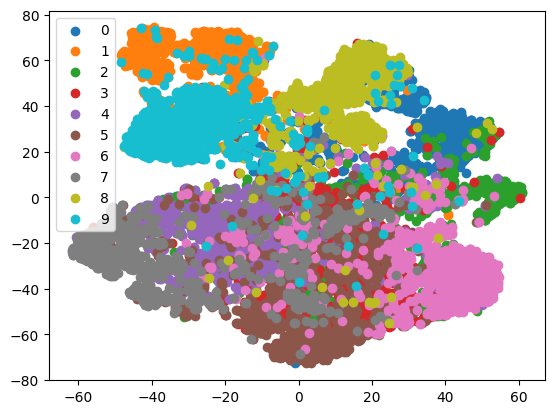

In [16]:
nr = 0
current_epoch = 0
epochs = 20
tr_loss = []
val_loss = []

for epoch in range(epochs):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dl):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(vdl)}]\t Loss: {round(loss.item(), 5)}")

        tr_loss_epoch += loss.item()

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    if nr == 0 and (epoch+1) % 50 == 0:
        save_model(model, optimizer, mainscheduler, current_epoch,"SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = 0
        for step, (x_i, x_j) in enumerate(vdl):
        
          x_i = x_i.squeeze().to('cuda:0').float()
          x_j = x_j.squeeze().to('cuda:0').float()

          # positive pair, with encoding
          z_i = model(x_i)
          z_j = model(x_j)

          loss = criterion(z_i, z_j)

          if nr == 0 and step % 50 == 0:
              print(f"Step [{step}/{len(dl)}]\t Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()

    if nr == 0:
        tr_loss.append(tr_loss_epoch / len(dl))
        val_loss.append(val_loss_epoch / len(vdl))
        print(f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dl)}\t lr: {round(lr, 5)}")
        print(f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}")
        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model.pretrained, 10, 2048, 128)

save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")
